
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

from beacs.agents.beacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_performance

from beacs.metrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _state_of_population, \
    _enhanced_effect_error

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "Maze10-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
BETA_ALP = 0.05
BETA_RL = 0.05
EPSILON = 0.8

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#BEACS Set Up
DO_GA = False
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ A ■ ■ □ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ □ ■ ■ ■ ■ ■
■ ■ ■ $ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 1min 59s, sys: 921 ms, total: 2min
Wall time: 2min 7s


### Performance

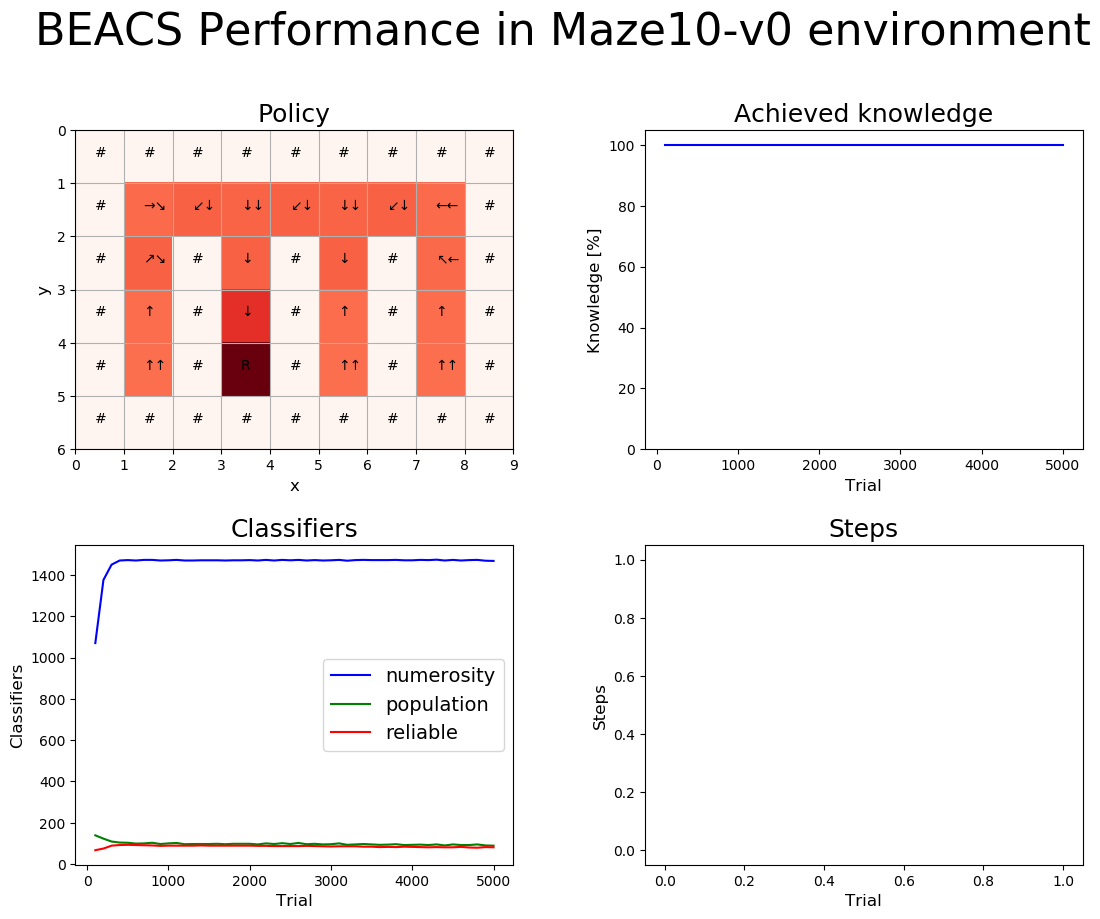

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
print(_maze_metrics(population_explore, maze))

first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)

print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.")

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

print(_state_of_population(metrics_explore, last_trial, METRICS_TRIAL_FREQUENCY_EXPLORE))

old_error, new_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities : old->", old_error, "% new->", new_error, "%")

{'knowledge': 100.0, 'population': 89, 'numerosity': 1468, 'reliable': 81}
Full knowledge was achieved at trials  100 , was stable at  100  and the last time it was achieved at  5000
There are  0  enhanced classifer(s) that match a non-aliased states.
Mean reliable population specifity is  0.6481481481481481
{'trial': 5000, 'steps_in_trial': 100, 'reward': 0, 'knowledge': 100.0, 'population': 89, 'numerosity': 1468, 'reliable': 81}
Accumulated Error on PEP Probabilities : old-> 0.22409198280005774 % new-> 0.22409198280005774 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore
    if cl.does_match('11010101')]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

110##101 4 [4] (0#1###1#:#4764, 0#1#9#1#:#3439) (empty)
q: 1.0    ra: 771.5  rb: 780.6  ir: 0.0    f: 771.5  err: -25.29
exp: 8202  num: 17 ee: False PAI_state: 00110110
tga: 226844 tbseq: 3945  talp: 226922 tav: 27.3   



1101#101 4 [4] (0#1###1#:#4763, 0#1#9#1#:#3439) (empty)
q: 1.0    ra: 770.2  rb: 780.4  ir: 0.0    f: 770.2  err: -24.85
exp: 8201  num: 1 ee: False PAI_state: 00110110
tga: 226844 tbseq: 4184  talp: 226922 tav: 27.3   



#######1 7 None (########:#1) (empty)
q: 1.0    ra: 756.4  rb: 743.4  ir: 0.0    f: 756.4  err: -12.68
exp: 5687  num: 20 ee: False PAI_state: 
tga: 226882 tbseq: 226829 talp: 226882 tav: 45.13  



##01010# 2 [6] (########:#1) (empty)
q: 1.0    ra: 755.7  rb: 746.7  ir: 0.0    f: 746.7  err: -0.4474
exp: 1186  num: 18 ee: False PAI_state: 11001001
tga: 226776 tbseq: 3348  talp: 226776 tav: 199.4  



110##101 4 None (001###10:#1) (empty)
q: 1.0    ra: 738.0  rb: 746.4  ir: 0.0    f: 746.4  err: 1.432 
exp: 1678  num: 20 ee: False PAI_state: 
tga:

In [8]:
agent_explore.get_pai_states_memory()

[('1', '1', '0', '0', '1', '0', '0', '1'),
 ('0', '0', '1', '1', '0', '1', '1', '0'),
 ('0', '1', '1', '1', '0', '1', '1', '1')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 11.4 s, sys: 146 ms, total: 11.6 s
Wall time: 12.5 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 7.31 s, sys: 101 ms, total: 7.42 s
Wall time: 9.05 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 6.2 s, sys: 55.5 ms, total: 6.25 s
Wall time: 6.89 s


### Performance

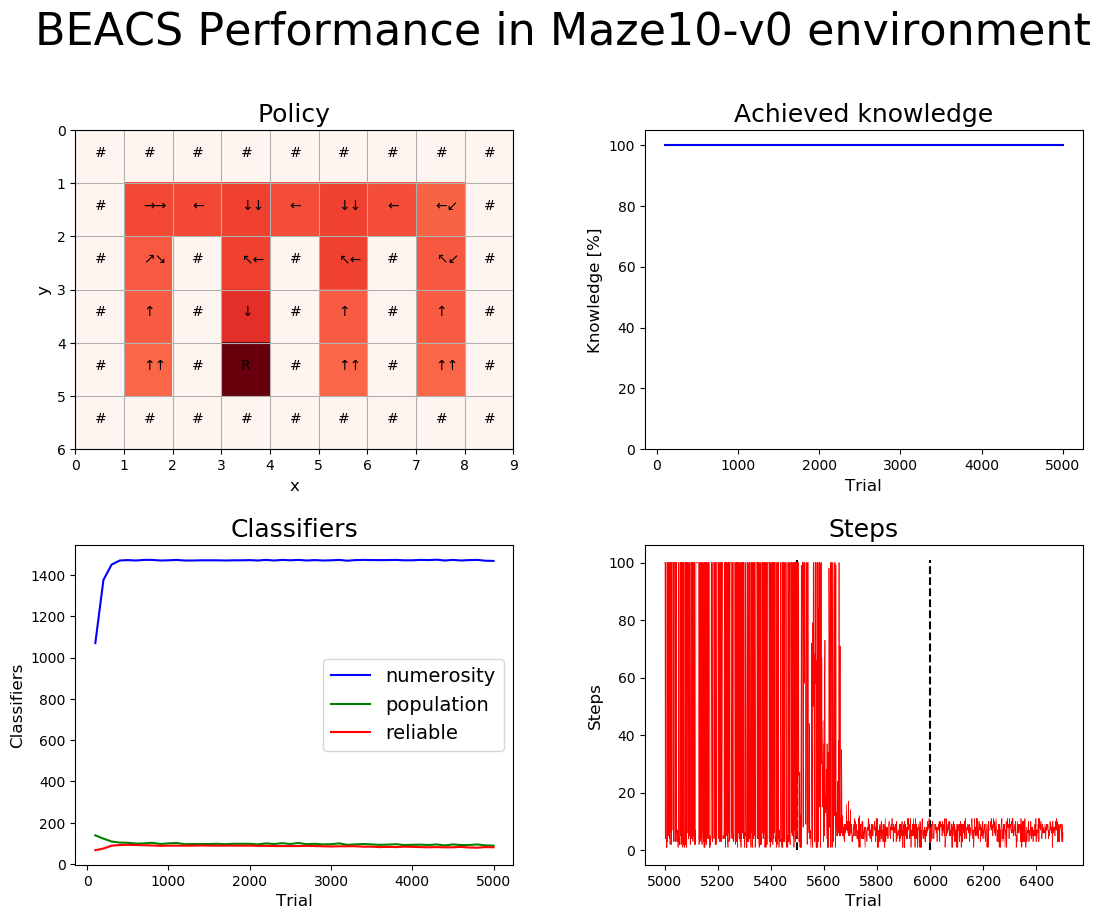

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  40.72  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  50.18  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  18.248  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  6.886  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 89, 'numerosity': 1468, 'reliable': 81}
{'knowledge': 100.0, 'population': 89, 'numerosity': 1468, 'reliable': 81}
{'knowledge': 100.0, 'population': 89, 'numerosity': 1468, 'reliable': 81}
{'knowledge': 100.0, 'population': 89, 'numerosity': 1468, 'reliable': 81}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl 
    if cl.behavioral_sequence or cl.is_enhanced()]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")
#from beacs.agents.beacs import ClassifiersList
#print(len(ClassifiersList(*list(dict.fromkeys(population_exploit_rl_to_display)))))

59


#1##9##1 0 [4] (########:#1) (empty)
q: 1.0    ra: 942.9  rb: 950.0  ir: 0.0    f: 942.9  err: 4.31  
exp: 2701  num: 20 ee: False PAI_state: 00110110
tga: 226583 tbseq: 2257  talp: 226583 tav: 79.92  



1101#101 4 [4] (0#1###1#:#4763, 0#1#9#1#:#3439) (empty)
q: 1.0    ra: 908.3  rb: 925.3  ir: 0.0    f: 908.3  err: -10.1 
exp: 9578  num: 1 ee: False PAI_state: 00110110
tga: 226844 tbseq: 4184  talp: 226922 tav: 27.3   



110##101 4 [4] (0#1###1#:#4764, 0#1#9#1#:#3439) (empty)
q: 1.0    ra: 905.8  rb: 932.8  ir: 0.0    f: 905.8  err: -10.36
exp: 9579  num: 17 ee: False PAI_state: 00110110
tga: 226844 tbseq: 3945  talp: 226922 tav: 27.3   



1##1011# 2 [2] (######0#:#1) (empty)
q: 1.0    ra: 890.6  rb: 879.6  ir: 0.0    f: 879.6  err: -0.3298
exp: 1024  num: 20 ee: False PAI_state: 11001001
tga: 226570 tbseq: 3582  talp: 226570 tav: 515.8  



00110110 7 [6] (110####1:#486, 110###01:#961) (empty)
q: 1.0    ra: 873.3  rb: 866.1  ir: 0.0    f: 866.1  err: 0.5471
exp: 2104  num: 20